# Explore 2023 hackweek model predictions
This ResDepth CNN was trained during the 2023 GeoSMART Hackweek. This version has been retrained on an updated dataset. 

In [5]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import deep_snow.models
import deep_snow.dataset

In [7]:
# grab data paths
val_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

test_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/test'
test_path_list = glob(f'{test_data_dir}/ASO_50M_SD*.nc')

In [8]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
val_data = deep_snow.dataset.Dataset(val_path_list, selected_channels, norm=True, augment=False)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=False)

# prepare training and validation dataloaders
test_data = deep_snow.dataset.Dataset(test_path_list, selected_channels, norm=True, augment=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=True)

In [9]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'delta_cr',
    'green',
    'swir2',
    'ndsi',
    'ndwi',
    'elevation',
    'latitude',
    'longitude']

In [10]:
#load previous model
model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load('../../weights/quinn_ResDepth_v11_298epochs'))
model.to('cuda');

/tmp/ipykernel_8776/877063291.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../weights/quinn_ResDepth_v11_298epochs'))


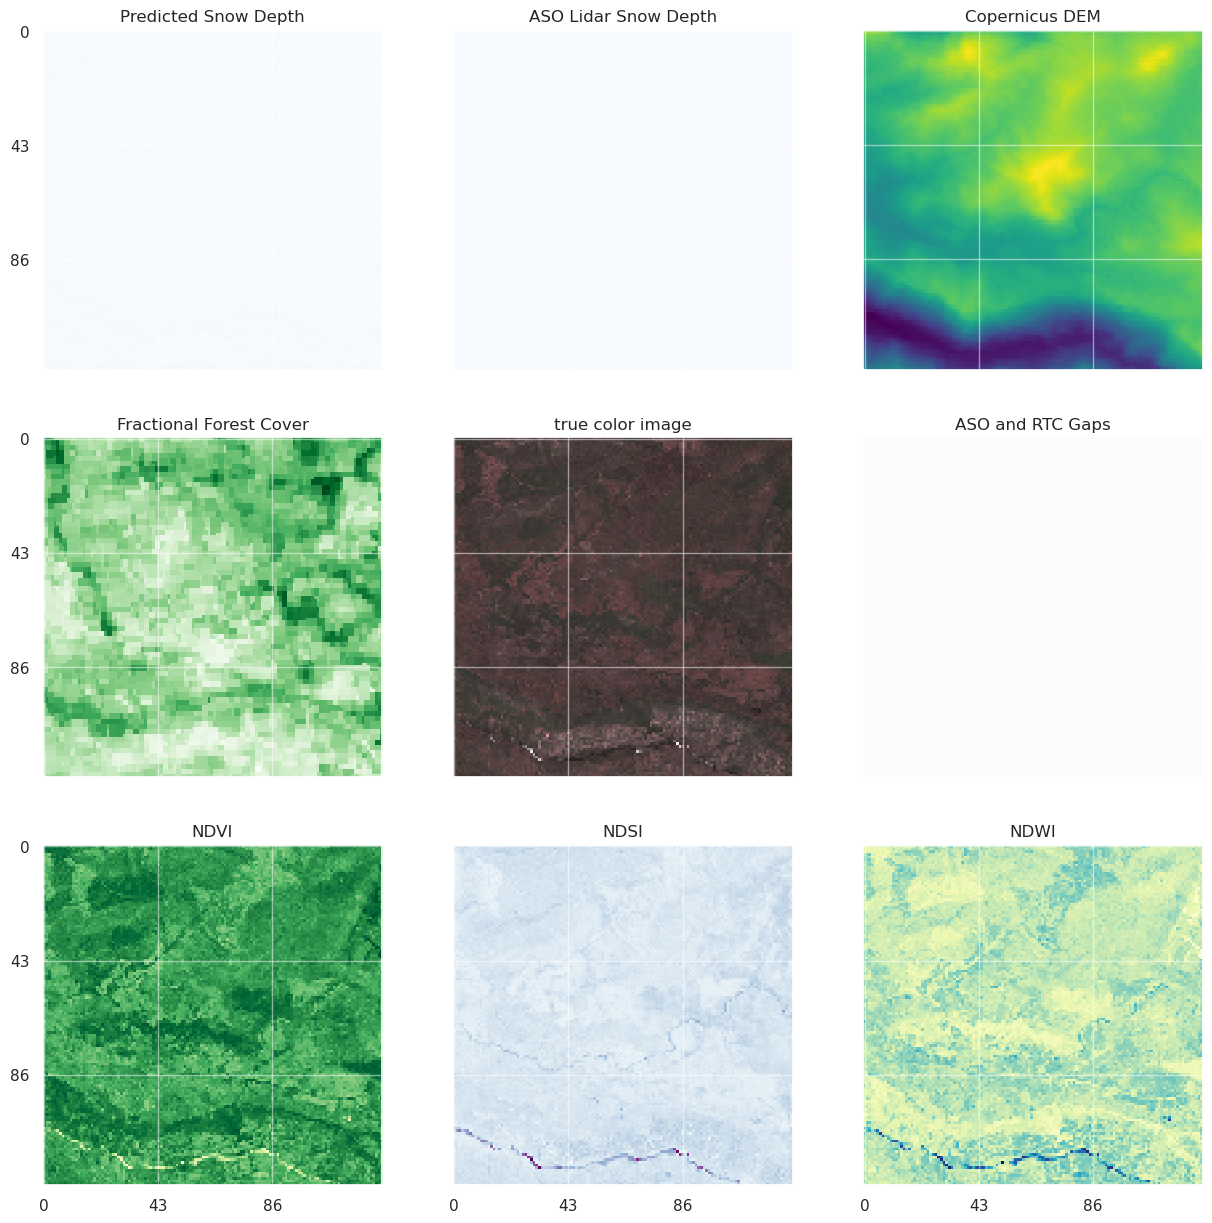

In [102]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), vmin=0, cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        # f.tight_layout()
    else:
        break

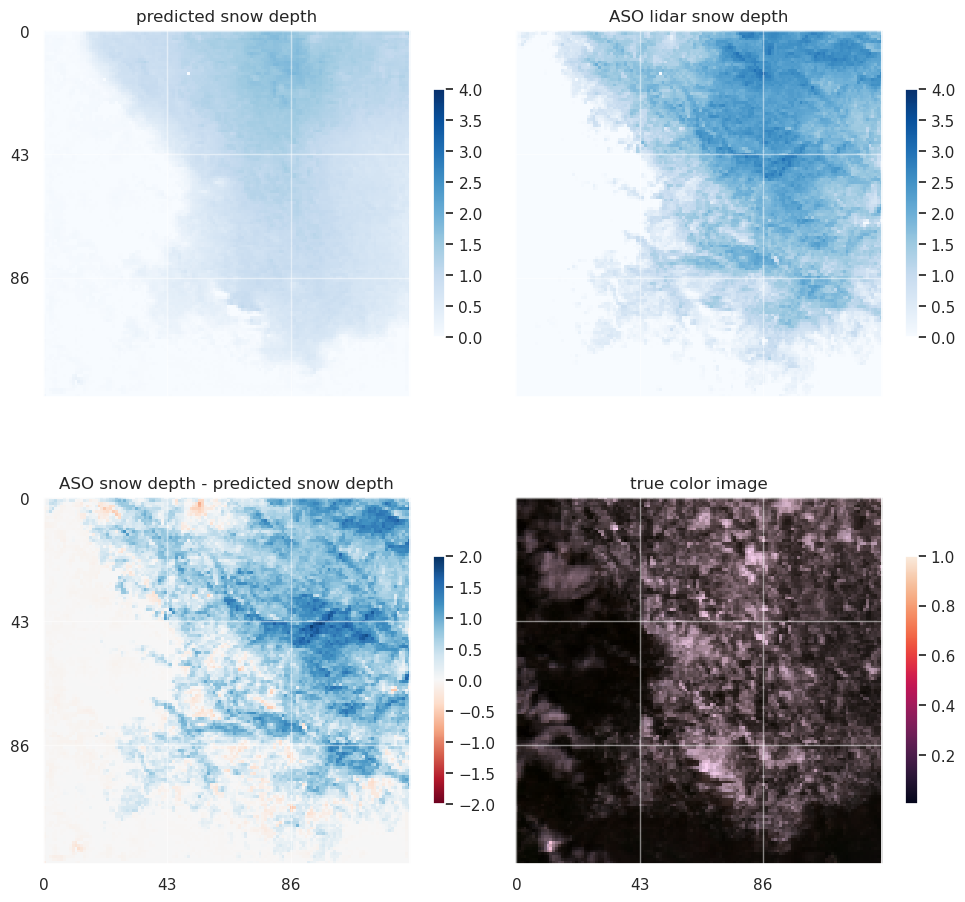

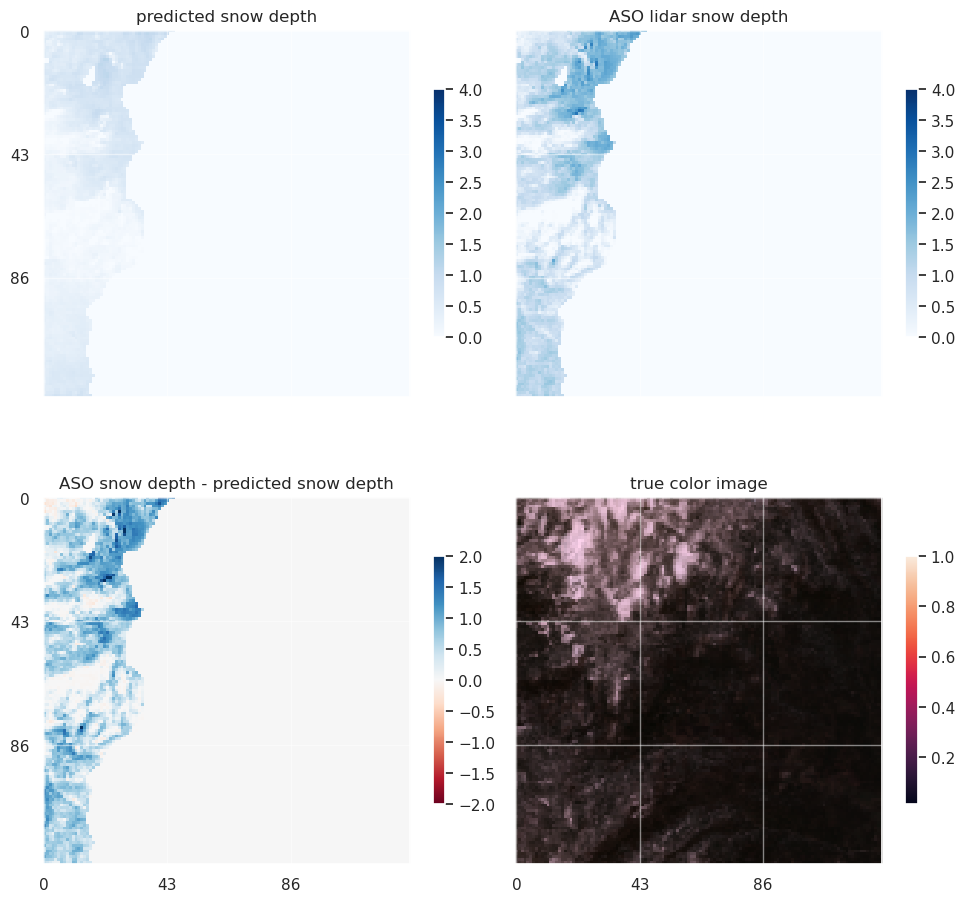

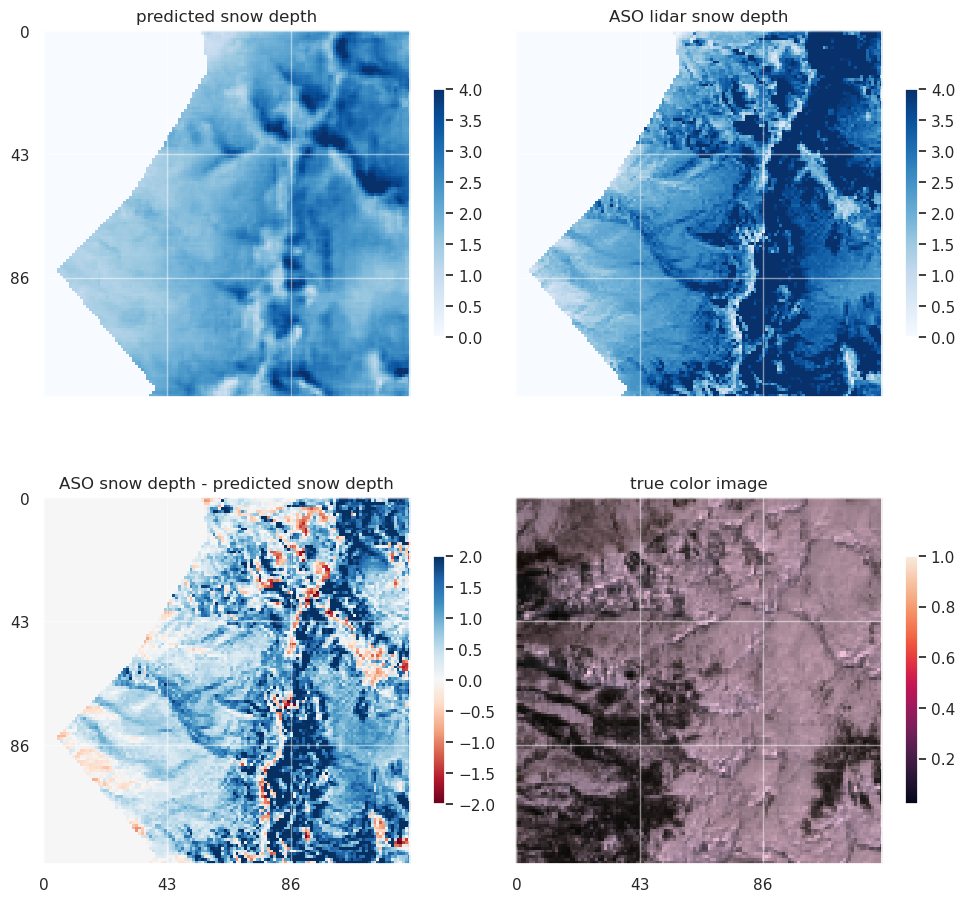

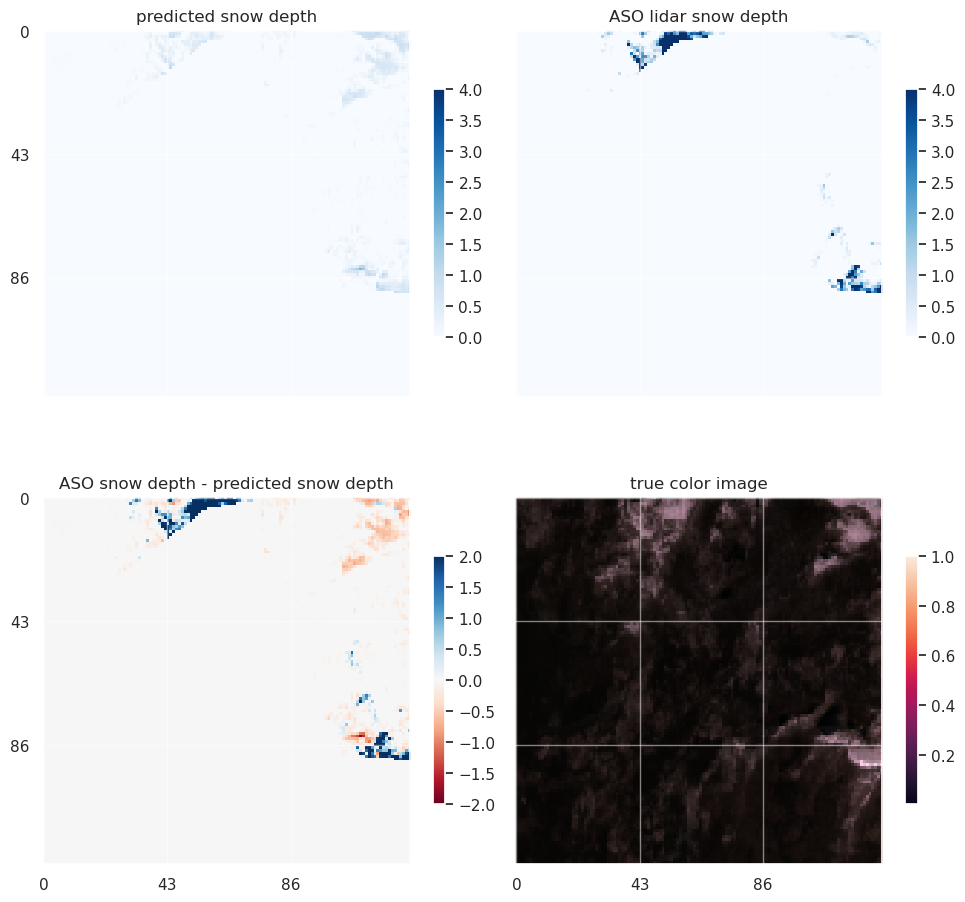

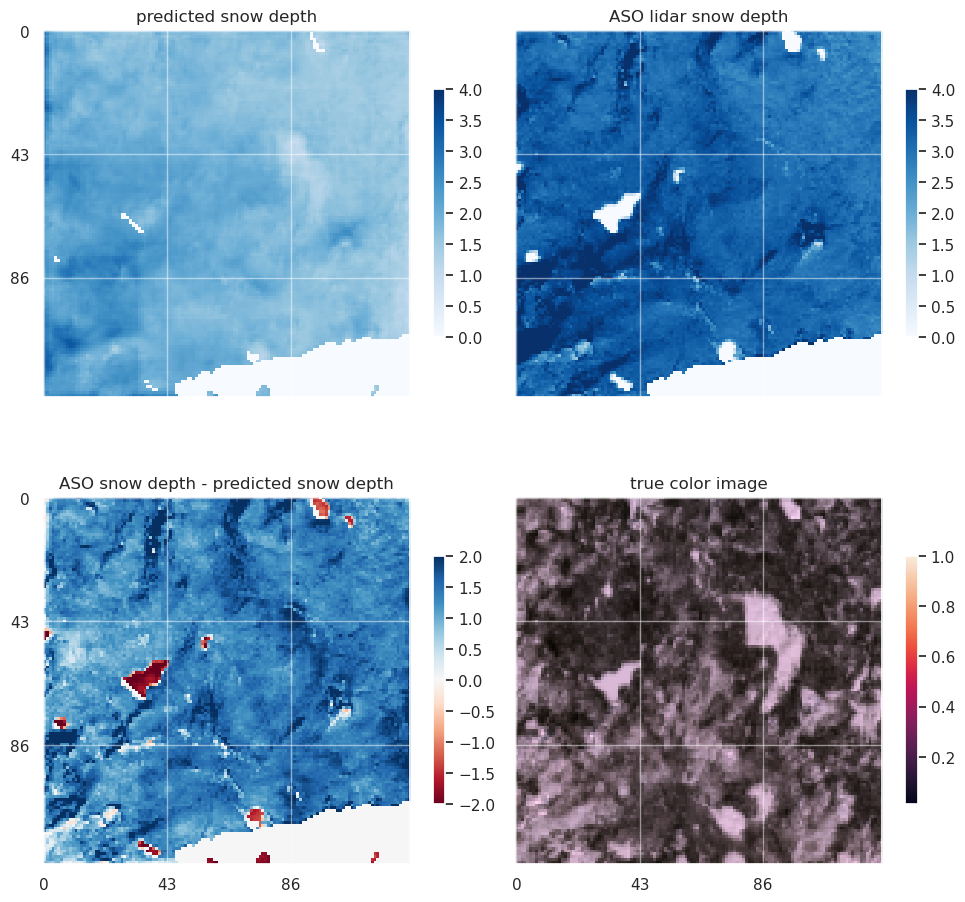

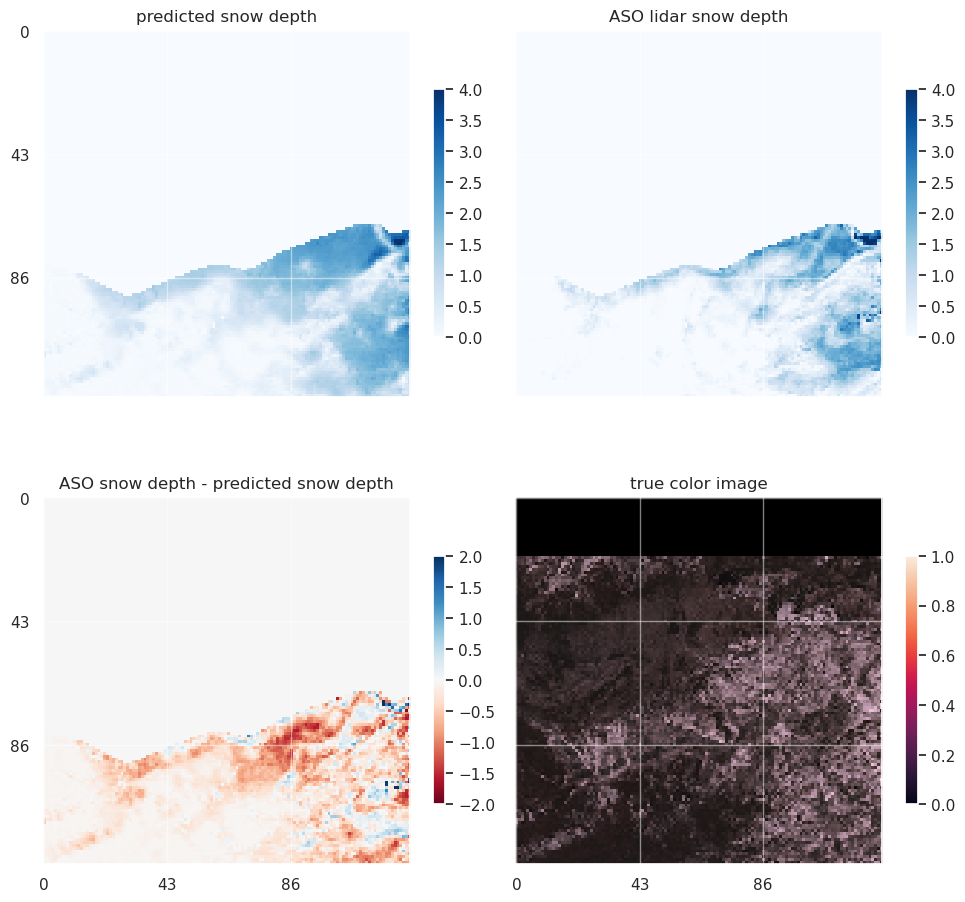

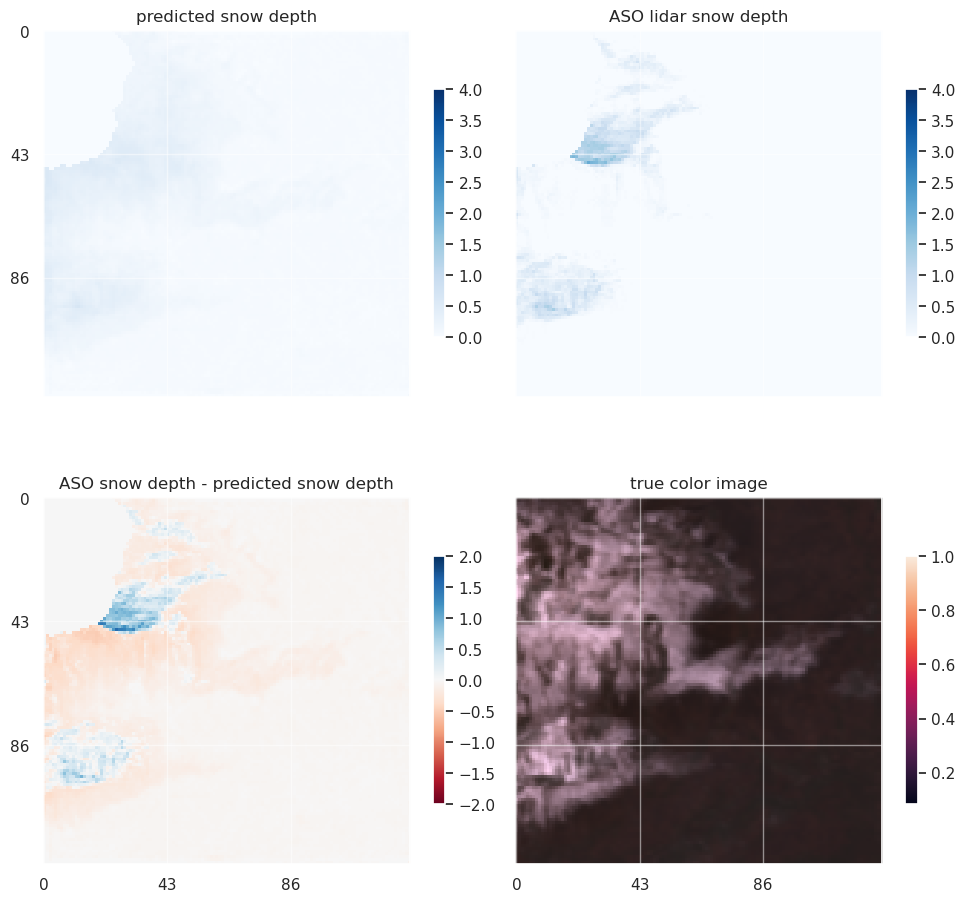

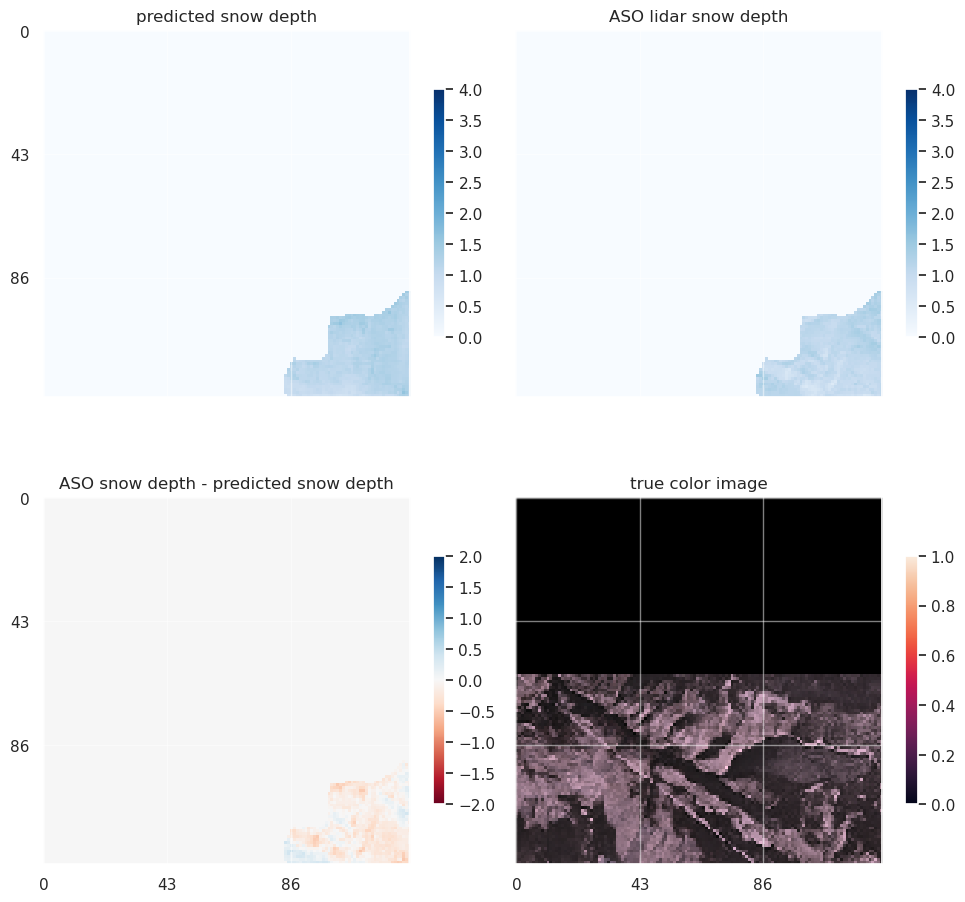

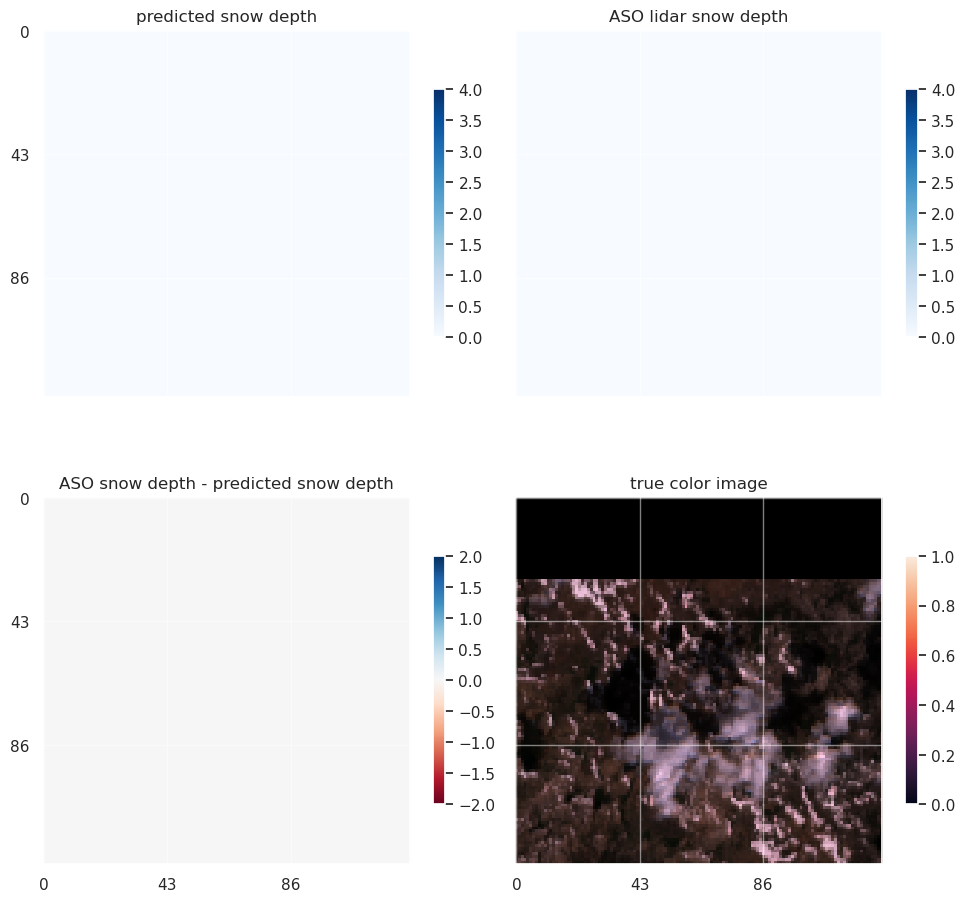

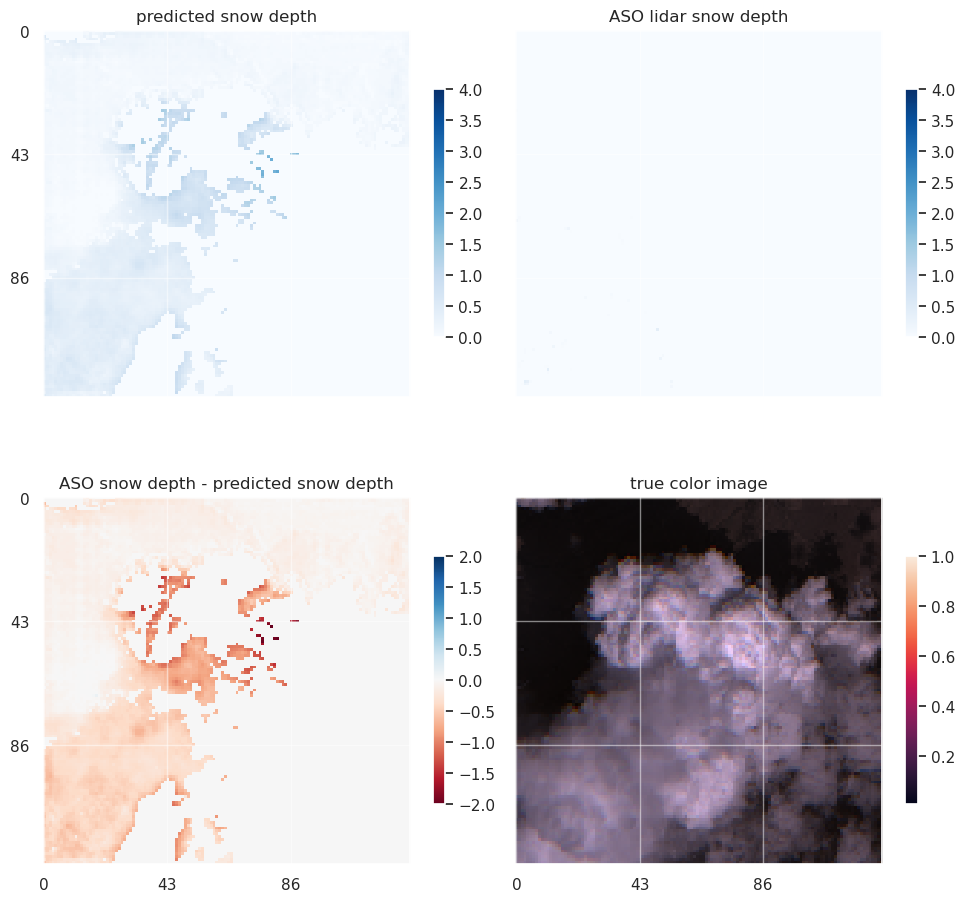

In [13]:
# visualize prediction error
sns.set_theme()
num_samples = 10
norm_dict = deep_snow.dataset.norm_dict

for i, data_tuple in enumerate(test_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map']== 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = deep_snow.dataset.undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = deep_snow.dataset.undo_norm(aso_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=4, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=4, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # Set modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break

In [11]:
# scatterplot of predicted values vs target values for entire dataset
# **CAUTION: this plot can take a long time to run**

from matplotlib.colors import LogNorm

def plot_rmse(value_list, target_list, binwidth=0.25, axmin=-5, axmax=15):
    '''
    Plot binned values of two lists agains one another on a log scale
    '''
    sns.set_theme()
    
    f, ax = plt.subplots(1, 1, figsize=(3.5,3.5))

    sns.histplot(ax=ax, x=target_list, y=value_list, 
                 cmap='Greens', cbar=True, alpha=1, binwidth=binwidth, vmin=None, vmax=None, norm=LogNorm())
    ax.plot([-15, 15], [-15, 15], color='k', linestyle='-', linewidth=1, alpha=0.3)
    ax.set_xlabel('ASO snow depth (m)')
    ax.set_ylabel('predicted snow depth')
    ax.set_box_aspect(1)
    ax.set_xlim(axmin, axmax)
    ax.set_ylim(axmin, axmax)
    ax.set_xticks([-5, 0,5,10,15])
    ax.set_yticks([-5, 0,5,10,15])
    f.tight_layout()
    f.savefig('../../figs/quinn_ResDepthv9_115epochs_performance.png', dpi=400)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def list_plot(data, data_loader, norm_dict):
    # init lists
    pred_array = np.array([])
    target_array = np.array([])

    for i, data_tuple in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')

        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
        
        with torch.no_grad():
            pred_sd = model(inputs)

        # undo normalization
        aso_sd = deep_snow.dataset.undo_norm(data_dict['aso_sd'], norm_dict['aso_sd'])
        pred_sd = deep_snow.dataset.undo_norm(pred_sd.squeeze().to('cpu'), norm_dict['aso_sd'])

        # mask missing values
        pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, np.nan).squeeze()
        aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, aso_sd, np.nan).squeeze()

        # convert to 1d lists for plotting
        pred_array = np.append(pred_array, pred_sd)
        target_array = np.append(target_array, aso_sd)
    
    pred_array = pred_array[~np.isnan(pred_array)]
    target_array = target_array[~np.isnan(target_array)]

    # mask values below 0
    pred_array = np.where(pred_array < 0, 0, pred_array)

    return pred_array, target_array

pred_array, target_array = list_plot(test_data, test_loader, deep_snow.dataset.norm_dict)
    
# Calculate metrics
r2 = r2_score(target_array, pred_array)
mse = mean_squared_error(target_array, pred_array)
mae = mean_absolute_error(target_array, pred_array)

print(f'R²: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

loop 500/1516
loop 1000/1516
loop 1500/1516
R²: 0.6315823274311849
MSE: 0.8599400716421124
MAE: 0.620766249913467


In [21]:
from scipy.stats import pearsonr

# Calculate Pearson's r
r, _ = pearsonr(target_array, pred_array)
print(r)

0.9168221501437418


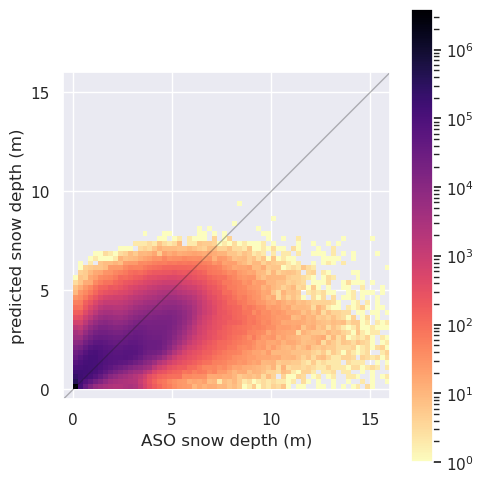

In [12]:
sns.set_theme()
axmin = -0.5
axmax = 16
    
f, ax = plt.subplots(1, 1, figsize=(5,5))

sns.histplot(ax=ax, x=target_array, y=pred_array,
             cmap='magma_r', cbar=True, alpha=1, binwidth=0.25, vmin=None, vmax=None, norm=LogNorm())
ax.plot([-15, 30], [-15, 30], color='k', linestyle='-', linewidth=1, alpha=0.3)
ax.set_xlabel('ASO snow depth (m)')
ax.set_ylabel('predicted snow depth (m)')
ax.set_box_aspect(1)
ax.set_xlim(axmin, axmax)
ax.set_ylim(axmin, axmax)
ax.set_xticks([0,5,10,15])
ax.set_yticks([0,5,10,15])

# sns.kdeplot(ax=axs.ax_marg_x, target_array)
# sns.kdeplot(axs.ax_marg_y, pred_array)

f.tight_layout()

f.savefig('../../figs/quinn_ResDepthv11_298epochs_performance.png', dpi=400)

In [ ]:
plot_rmse(pred_array, target_array)